<a href="https://colab.research.google.com/github/FedericoRaschiatore0123/GATr_Deep_Learning_Project/blob/main/GATr_deep_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Description**

In this project we implemented our version of GATr "Geometric Algebra Transformer" as described in paper [1].
To test this model we used the dataset Wall Shear Stress for Vessel Classification as specified in [2]. This file has big dimensions so we decided to split it in 1 file for each vessel. The script to split this files is on github at the following link https://github.com/FedericoRaschiatore0123/GATr_Deep_Learning_Project/blob/main/dataset_preparation.ipynb

In this Notebook instead you can find all the procedure to from the original format data to the Geometric Algebra multivectors and the geometric algebra operations.

We also implemented:
* A Simple Baseline that uses as input the raw datas (not in Geometric Algebra)
* A Baseline Transformer uses the Geometric Algebra datas as input to a standard transformer as described in the paper [5]
* The GATr as specified in the paper [1]

We tested all the geometric algebra models and we also check the equivariance of the GATr's layers respect to the GA operations.


# References
[1]  Geometric Algebra Transformer 2023 ( by
Johann Brehmer Pim de Haan Sönke Behrends Taco Cohen )

[2] Mesh Neural Networks for SE(3)-Equivariant Hemodynamics Estimation on the Artery Wall 2022 ( by Julian Suk, Pim de Haan, Phillip Lippe, Christoph Brune, Jelmer M. Wolterink )

[3] Clifford Geometric Algebra https://clifford.readthedocs.io/en/latest/

[4] A Guided Tour to the Plane-Based Geometric Algebra PG ( by Leo Dorst & Steven De Keninck )

[5] Attention Is All You Need ( by
Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin )

#Imports

In this section we clone the repository in order to import all the input datas and we install all the necessary dependencies

In [1]:
!git clone https://github.com/FedericoRaschiatore0123/GATr_Deep_Learning_Project.git

Cloning into 'GATr_Deep_Learning_Project'...
remote: Enumerating objects: 4398, done.
remote: Counting objects: 100% (278/278), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 4398 (delta 230), reused 141 (delta 108), pack-reused 4120
Receiving objects: 100% (4398/4398), 1.72 GiB | 15.61 MiB/s, done.
Resolving deltas: 100% (301/301), done.
Updating files: 100% (4005/4005), done.


In [2]:
# Libraries
!pip install pytorch_lightning --quiet
!pip install h5py
!pip install trimesh
!pip install torch_geometric
!pip install pyquaternion
!pip install clifford
!pip install einops

from torchmetrics.classification import BinaryAccuracy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch_geometric.data
import torchsummary
from torch_geometric.data import Data
from torch.utils.data import random_split, ConcatDataset, Subset
from pyquaternion import Quaternion
import clifford as cf
import pytorch_lightning as pl
import math
from einops import rearrange
from torch.nn import GELU
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchmetrics.classification import BinaryPrecision, BinaryRecall, BinaryF1Score
import time
import seaborn as sns

import h5py
import os
import trimesh
import random



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 694.6/694.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.3/159.3 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.8 MB/s eta 0:00:00


#Global Variables

In this section we specified all the necessary variables in order to control all the variables in a centralized way.

In [3]:
# create a dictionary of global variables
global_variables = {

    'single_path' : '/content/GATr_Deep_Learning_Project/single/',
    'bifurcating_path' : '/content/GATr_Deep_Learning_Project/bifurcating/',

    'length_data' : 50,
    'mv_dimension' : 16,
    'mv_channels' : 4,
    'hidden_dim_mv' : 8,

    'num_heads' : 2,
    'out_channels' : 1,
    'num_classes' : 2,
    "patience" : 3,
    "factor" : 0.1,
    "dropout" : 0.1,

    'batch_size' :  64,
    'num_workers' : 2,

    'dim_input_MLP' : 10,
    'batch_size_MLP' : 32,

    'dim_GA' : 16,
    'hidden_dim' : 8,

    'geometric_guidance' : '/content/GATr_Deep_Learning_Project/data/geometric_product.pt',
    'outer_guidance' : '/content/GATr_Deep_Learning_Project/data/outer_product.pt',
}

#Get device

In this section we setted the device

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device('cpu')

#Show data

In this section we display one example of the input data for each class using the trimesh library. This has been useful in order to understand the shape of the input data and the aim of this dataset.

In [5]:
# Samples of the dataset are shown for both classes (single, bifurcating) using trimesh

single_list = os.listdir(global_variables['single_path'])

with h5py.File(global_variables['single_path'] + single_list[random.randint(0, len(single_list))] , 'r') as file:

    vertices = np.array(file['pos'])
    faces = np.array(file['face'])

mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
mesh.show()

In [6]:
bifurcating_list = os.listdir(global_variables['bifurcating_path'])

with h5py.File(global_variables['bifurcating_path'] + bifurcating_list[random.randint(0, len(bifurcating_list))] , 'r') as file:
    vertices = np.array(file['pos'])
    faces = np.array(file['face'])

mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
mesh.show()

#Utilities

In this section we have some functions that are useful to show some results. This are:

*   Compute_precision_recall_f1score ( used to compute precision recall and f1 score )
*   Check balancing ( used to visualize the distribution of the data between the two classes through an histogram)
*   Confusion matrix  ( display the confusion matrix of the results )
*   Scatterplot ( display the distribution of the datas referring to wss and pressure values )



In [7]:
def show_graph(losses):
  """
  Show the graph of the losses
  """
  plt.plot(losses)
  plt.grid()
  plt.show()

In [8]:
def compute_precision_recall_f1score(true_label, pred_label):
    """
    Calculate precision, recall, and F1 score.

    Input:
      true_label  Real labels.
      pred_label  Predicted labels.

    Output:
      Dictionary containing precision, recall, and F1 score.
    """
    precision = precision_score(true_label, pred_label, average='binary')
    recall = recall_score(true_label, pred_label, average='binary')
    f1 = f1_score(true_label, pred_label, average='binary')

    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

In [9]:
def check_balancing(dataset):
  """
  This function is used to visualize the distribution of the data between the two classes through an histogram.
  Input:
    dataset (torch.Tensor)

  Output:
    histogram representing the distribution of the samples
  """
  label = []
  for _ , element in enumerate(dataset):
    label.append(element[-1])

  categories = ['Single ' +  str(label.count(0)), 'Bifurcating ' +  str(label.count(1))]

  fig, ax = plt.subplots(figsize = (8,5))

  bars = ax.bar(
      categories,
      [label.count(0), label.count(1)],
      align = 'center'
    )

  ax.set_xlabel('Labels')
  ax.set_ylabel('Number of occurences')

  plt.ylim(ymax = len(label))
  plt.show()

In [10]:
def confusion_matrix_display(true_label, pred_label):
  """
  This function uses the library sklearn.metrics to display the confusion matrix of the results

  Input:
    true_label (torch.Tensor)
    pred_label (torch.Tensor)

  Output:
    confusion_matrix representing the samples classified correctly and not
  """

  cm = confusion_matrix(true_label, pred_label)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(cmap=plt.cm.Blues)
  plt.show()


In [11]:
def scatter_plot():

  single_list = os.listdir(global_variables['single_path'])
  bifurcating_list = os.listdir(global_variables['bifurcating_path'])

  single_press = []
  single_wss = []
  bifurcating_press = []
  bifurcating_wss = []

  for single_file in single_list:

    with h5py.File(global_variables['single_path'] + single_file , 'r') as file:

      single_press.append(np.array(file['pressure']).mean() * 1e-3)

      single_wss.append(np.array(file['wss']).mean())

  for bifurcarting_file in bifurcating_list:

    with h5py.File(global_variables['bifurcating_path'] + bifurcarting_file , 'r') as file:

      bifurcating_press.append(np.array(file['pressure']).mean() * 1e-3)

      bifurcating_wss.append(np.array(file['wss']).mean())

  pressure = [ bifurcating_press, single_press]
  wss = [ bifurcating_wss, single_wss]

  fig, ax = plt.subplots(figsize = (10,7))

  ax.scatter(
      single_press,
      single_wss,
      label = 'Single',
      alpha = 0.3
    )

  ax.scatter(
      bifurcating_press,
      bifurcating_wss,
      label = 'Bifurcating',
      alpha = 0.3
    )

  ax.set_title('Scatterplot between mean WSS e Pressure')

  ax.legend()
  plt.show()

# Geometric Algebra

Geometric algebra $G_{3,0,1}$ is used to extend the space $\mathbb{R}^{3}$ into an equivalent 16-dimensional space that encodes the basic geometric elements (points, planes, lines...) as well as transformations such as rotations, translations and reflections. $G_{3,0,1}$ indicates that the space is characterized by four generators ($e_{0}$, $e_{1}$, $e_{2}$, $e_{3}$). In particular, three of them ($e_{1}$, $e_{2}$, $e_{3}$) satisfy $e_{i}e_{i} = 1$, while the remaining one satisfies $ e_{0}e_{0} = 0 $. TODO: add source

The basis components of the multivector associated to the G_{3,0,1} algebra are obtained by considering every possible multiplicative combination of the basis elements. Elements of different grade are thus obtained:

Grade 0 ($1$): scalars in the G.A. \\
Grade 1 ($e_{0}$, $e_{i}$): vectors in the G.A. \\
Grade 2 ($e_{0i}$, $e_{ij}$); bivectors in the G.A. \\
Grade 3 ($e_{0ij}$, $e_{ijk}$): trivectors in the G.A. \\
Grade 4 ($e_{0123}$): pseudoscalars in the G.A. \\

The multivector representation associated to the Geometric Algebra G_{3,0,1} will thus be composed of a total of 16 elements.

Scalars will be represented by grade 0 elements, planes by grade 1 elements, lines by grade 2 elements, points by grade 3 elements and pseudoscalar by grade 4 elements.

## Definition of the embeddings
Each sample of the dataset represents a portion of an artery and is characterized by a set of 3D points (pos), a set of plane faces each delimited by 3 points (faces), a set of wall sheer stress vectors (wss), a set of inlet indeces (inlet_idcs), and a set of pressure values (pressure).
The data is encoded using the definitions provided in arcicle TODO cite, and shown below. Before the embedding procedure, the data is standardized. \\
NOTE: The inlet indices are a set of natural numbers that identify the indices of the 3D points that lie on the entrance border of the artery. For the task of classifying the arteries, they are not as rich in information as the other components of the data samples. Thus, the multivectors corresponding to the inlet indeces are not included in the total concatenated embedding of the samples. Nevertheless, the definition of their embedding is provided for the sake of completeness.

<center>

![Baseline](https://drive.google.com/uc?export=download&id=1f7fpn1U784RmHogDEwdFrd8ptaMhVS1C)

</center>

In [12]:
def embed_pos_mv_16(pos):
    """
    Embeds the pos torch tensor as a 16-dimensional G_{3,0,1} multivector

    Args:
        pos (torch.Tensor): tensor of input points with shape (n_elements, 3)

    Returns:
        pos_mv torch.Tensor: tensor of multivectors of dimension 16 with shape (1, n_elements, 1, 16)
    """
    # Positions in Euclidean geometry can be embedded as points in G_{3,0,1} algebra

    # Get the number of points and the dimensionality
    n_elements = pos.shape[0]
    dim = pos.shape[1]

    # Create multivector tensor
    multivector = torch.zeros(n_elements, global_variables['dim_GA'])

    multivector[:, 14] = 1 # homogeneous component, e_{123}
    multivector[:, 11] = pos[:, 0] # x, e_{023}
    multivector[:, 12] = pos[:, 1] # y, e_{013}
    multivector[:, 13] = pos[:, 2] # z, e_{012}

    pos_mv = multivector.reshape(1,n_elements,1,global_variables['dim_GA'])

    return pos_mv

In [13]:
def embed_face_mv_16(face):
    """
    Embeds the face torch tensor as a 16-dimensional G_{3,0,1} multivector

    Input:
        face torch.Tensor of size (n_elements, 3)
    Output:
        mv torch.Tensor of size (1, n_elements, 1, 16)
    """

    # An oriented surface in Euclidean geometry characterized by
    #   the normal vector n to the surface itself can be embedded as an oriented
    #   plane in G_{3,0,1} algebra


    # Get the number of points and the dimensionality of the space
    n_elements = face.shape[0]
    dim = face.shape[1]

    # Create multivector tensor
    multivector = torch.zeros(n_elements, global_variables['dim_GA'])

    multivector[:, 2] = face[:, 0] # e_{1}
    multivector[:, 3] = face[:, 1] # e_{2}
    multivector[:, 4] = face[:, 2] # e_{3}

    face_mv = multivector.reshape(1,n_elements,1,global_variables['dim_GA'])

    return face_mv

In [14]:
def embed_wss_mv_16(wss):
    """
    Embeds the wss vectors as a 16 dimensional G_{3,0,1} multivector
    Input:
      wss torch.Tensor of size (n_elements, 3)
    Output:
      wss_mv torch.Tensor of size (1, n_elements, 1, 16)
    """

    # A 3D vector in the Euclidean space can be embedded as a translation in G_{3,0,1} algebra

    n_elements = wss.shape[0]
    dim = wss.shape[1]

    multivector = torch.zeros(n_elements, global_variables['dim_GA'])

    multivector[:, 0] = 1
    multivector[:, 5] = 0.5*wss[:, 0] # e_{01}
    multivector[:, 6] = 0.5*wss[:, 1] # e_{02}
    multivector[:, 7] = 0.5*wss[:, 2] # e_{03}

    wss_mv = multivector.reshape(1,n_elements,1,global_variables['dim_GA'])

    return wss_mv

In [15]:
def embed_inlet_mv_16(inlet):
    """
    Embeds the inlet torch tensor as a 16 dimensional G_{3,0,1} multivector
    Input:
        inlet torch.Tensor of size (n_elements, 1)
    Output:
        inlet_mv torch.Tensor of size (1, n_elements, 1, 16)
    """
    # Inlet indexes can be embedded as scalars in G_{3,0,1} algebra

    n_elements = inlet.shape[0]

    multivector = torch.zeros(n_elements, global_variables['dim_GA'])
    multivector[:, 0] = inlet[:]

    inlet_mv = multivector.reshape(1, n_elements, 1, global_variables['dim_GA'])

    return inlet_mv

In [16]:
def embed_pressure_mv_16(pressure):
  """
  Embeds the pressure torch tensor as a 16-dimensional G_{3,0,1} multivector
  Input:
    pressure torch.Tensor of size (n_elements, 1)
  Output:
    pressure_mv torch.Tensor of size (1, n_elements, 1, 16)
  """

  n_elements = pressure.shape[0]

  # Initialize the multivector
  multivector = torch.zeros(n_elements, global_variables['dim_GA'])

  multivector[:,0] = pressure[:]
  pressure_mv = multivector.reshape(1, n_elements, 1, global_variables['dim_GA'])

  return pressure_mv

In [17]:
def embed_complete_mv_16(sample_path):
  """
  Embeds the artery sample into a concatenation of 4 16-dimensional multivectors in G_{3,0,1}.
  Each of the 4 multivectors embeds a different feature of the artery: pos, face, wss, pressure
  The data is standardized before the embedding
  Input:
    sample_path: path to the artery sample saved in hdf5 format
  Output:
    sample_embedding: torch.Tensor of size (1, length_data, 4, 16)
        where length_data is the number of points in the samples considered for the embedding
  """

  with h5py.File(sample_path, 'r') as f:
    # extract torch tensor for pos
    pos_data = f['pos'][:global_variables['length_data']]
    pos_torch = torch.tensor(pos_data[:])
    pos_torch_norm = (pos_torch - torch.mean(pos_torch)) / torch.std(pos_torch)

    # extract torch tensor for face
    face_data = f['face'][:global_variables['length_data']]
    face_torch = torch.tensor(face_data[:])

    # extract torch tensor for wss
    wss_data = f['wss'][:global_variables['length_data']]
    wss_torch = torch.tensor(wss_data[:])
    wss_torch_norm = (wss_torch - torch.mean(wss_torch)) / torch.std(wss_torch)

    # extract torch tensor for pressure
    pressure_data = f['pressure'][:global_variables['length_data']]
    pressure_torch = torch.tensor(pressure_data[:])
    pressure_torch_norm = (pressure_torch - torch.mean(pressure_torch)) / torch.std(pressure_torch)

  # Get the multivector embeddings for each torch tensor
  pos_mv_16 = embed_pos_mv_16(pos_torch_norm)
  face_mv_16 = embed_face_mv_16(face_torch)
  wss_mv_16 = embed_wss_mv_16(wss_torch_norm)
  pressure_mv_16 = embed_pressure_mv_16(pressure_torch_norm)

  sample_embedding = torch.cat(
      [pos_mv_16, face_mv_16, wss_mv_16, pressure_mv_16], dim = 2)

  return sample_embedding

In [18]:
# Use of embed_complete_mv_16

sample_path = "/content/GATr_Deep_Learning_Project/single/sample_0000.hdf5"
sample_embedding = embed_complete_mv_16(sample_path)
print(sample_embedding.shape)

torch.Size([1, 50, 4, 16])


## Geometric Algebra Transformations

Basic transformation operations are defined using the definitions provided in article TODO cite. The defined transformations are:


*   Reflection with respect to a plane;
*   Translation;
*   Reflection with respect to a point;
*   Rotation identified by a quaternion.


In [19]:
def embed_plane_reflection_mv_16(normal, d):
  """
  Embeds a plane reflection transformation given a normal vector and an origin shift
  as a 16-dimensional multivector in G_{3,0,1}
  Input:
    normal: torch.Tensor (1, 3) normal to the plane
    d: origin shift
  Output:
    pr_mv_16: torch.Tensor multivector of size (1,1,1,16) representing the plane reflection
    inv_pr_mv_16: torch.Tensor multivector of size (1,1,1,16) representing the inverse plane reflection
  """
  # Initialize the multivector
  plane_reflection_mv_16 = torch.zeros(1, global_variables['dim_GA'])

  plane_reflection_mv_16[0,1] = d
  plane_reflection_mv_16[0,2] = normal[0]
  plane_reflection_mv_16[0,3] = normal[1]
  plane_reflection_mv_16[0,4] = normal[2]

  pr_mv_16 = plane_reflection_mv_16.reshape(1,1,1,global_variables['dim_GA'])

  #Define the inverse plane reflection
  inv_plane_reflection_mv_16 = torch.zeros(1, global_variables['dim_GA'])

  inverse_shift = -d

  inv_plane_reflection_mv_16[0,1] = inverse_shift
  inv_plane_reflection_mv_16[0,2] = normal[0]
  inv_plane_reflection_mv_16[0,3] = normal[1]
  inv_plane_reflection_mv_16[0,4] = normal[2]

  inv_pr_mv_16 = inv_plane_reflection_mv_16.reshape(1,1,1,global_variables['dim_GA'])

  return pr_mv_16, inv_pr_mv_16

In [20]:
def embed_translation_mv_16(t):
  """
  Embeds a translation by a vector t in R^{3} as a 16-dimensional multivector in G_{3,0,1}
  Input:
    t: torch.Tensor of size (1, 3) representing a translation in the 3D space
  Output:
    tr_mv_16: torch.Tensor multivector of size (1,1,1,16) representing the translation
    inv_tr_mv_16: torch.Tensor multivector representing the inverse translation operation
  """
  # Initialize the multivector
  translation_mv_16 = torch.zeros(1, global_variables['dim_GA'])

  translation_mv_16[0,0] = 1 # homogeneous component
  translation_mv_16[0,5] = 0.5*t[0]
  translation_mv_16[0,6] = 0.5*t[1]
  translation_mv_16[0,7] = 0.5*t[2]

  tr_mv_16 = translation_mv_16.reshape(1,1,1,global_variables['dim_GA'])

  # define the inverse translation multivector
  # the transformation will be characterized by opposite translation vector: t -> -t
  inv_translation_mv_16 = torch.zeros(1, global_variables['dim_GA'])

  inv_t = -t

  inv_translation_mv_16[0,0] = 1 # homogeneous component
  inv_translation_mv_16[0,5] = 0.5*inv_t[0]
  inv_translation_mv_16[0,6] = 0.5*inv_t[1]
  inv_translation_mv_16[0,7] = 0.5*inv_t[2]

  inv_tr_mv_16 = inv_translation_mv_16.reshape(1,1,1,global_variables['dim_GA'])

  return tr_mv_16, inv_tr_mv_16

In [21]:
def embed_point_reflection_mv(p):
  """
  Embeds a reflection with respect to a point p in R^{3} as a 16-dimensional multivector in G_{3,0,1}
  Input:
    p: torch.Tensor of size (1,3) representing a point in 3D
  Output:
    pt_ref_mv_16: torch.Tensor of size (1,1,1,16) representing the point reflection
    inv_pt_ref_mv_16: torch.Tensor representing the inverse point reflection
  """
  # Initialize the multivector
  point_reflection_mv_16 = torch.zeros(1, global_variables['dim_GA'])

  point_reflection_mv_16[0,11] = p[0]
  point_reflection_mv_16[0,12] = p[1]
  point_reflection_mv_16[0,13] = p[2]
  point_reflection_mv_16[0,14] = 1

  # Reshape to match the shape of the other multivectors
  pt_ref_mv_16 = point_reflection_mv_16.reshape(1,1,1,global_variables['dim_GA'])

  # Definition of the multivector associated to the inverse operation
  # It is a reflection with respect to the opposite point

  inv_p = -p

  inv_point_reflection_mv_16 = torch.zeros(1, global_variables['dim_GA'])

  inv_point_reflection_mv_16[0,11] = inv_p[0]
  inv_point_reflection_mv_16[0,12] = inv_p[1]
  inv_point_reflection_mv_16[0,13] = inv_p[2]
  inv_point_reflection_mv_16[0,14] = 1

  inv_pt_ref_mv_16 = inv_point_reflection_mv_16.reshape(1,1,1,global_variables['dim_GA'])

  return pt_ref_mv_16, inv_pt_ref_mv_16

In [22]:
def embed_quaternion_rotation_mv_16(rot_axis, alpha):
  """
  Embeds a rotation defined by a quaterion through the axis angle rotation representation
  Input:
    rot_axis: list of size 1x3 representing the axis of the rotation [r1,r2,r3]
    alpha: float representing the angle of the rotation
  Output:
    quat_rot_mv_16: torch.Tensor of size (1,1,1,16) representing a rotation quaternion rotation
    inv_quat_rot_mv_16: torch.Tensor of size (1,1,1,16) representing a rotation quaternion rotation
  """
  quaternion = Quaternion(axis=rot_axis, angle=alpha)

  # Initialize the multivector
  quaternion_rotation_mv_16 = torch.zeros(1, global_variables['dim_GA'])

  quaternion_rotation_mv_16[0, 0] = quaternion.w
  quaternion_rotation_mv_16[0, 8] = quaternion.x
  quaternion_rotation_mv_16[0, 9] = quaternion.y
  quaternion_rotation_mv_16[0, 10] = quaternion.z

  quat_rot_mv_16 = quaternion_rotation_mv_16.reshape(1,1,1,global_variables['dim_GA'])

  # Definition of the inverse rotation
  # A new quaternion generated by the same axis and opposite angle of rotation is generated

  inv_alpha = -alpha

  inv_quaternion = Quaternion(axis=rot_axis, angle=inv_alpha)

  inv_quaternion_rotation_mv_16 = torch.zeros(1, global_variables['dim_GA'])

  inv_quaternion_rotation_mv_16[0, 0] = inv_quaternion.w
  inv_quaternion_rotation_mv_16[0, 8] = inv_quaternion.x
  inv_quaternion_rotation_mv_16[0, 9] = inv_quaternion.y
  inv_quaternion_rotation_mv_16[0, 10] = inv_quaternion.z

  inv_quat_rot_mv_16 = inv_quaternion_rotation_mv_16.reshape(1,1,1,global_variables['dim_GA'])

  return quat_rot_mv_16, inv_quat_rot_mv_16

#Blades

The projection of a multivector $x$ in the subspace of grade $k$ is denoted as the $\bf{blade}$ of grade $k$ of the multivector. Blades are used to define an equilinear map $\phi$ between two elements of the multivector space:

$$ \phi(x) = \sum_{k=0}^{d+1}w_{k}<x>_{k} + \sum_{k=0}^{d}v_{k} e_{0}<x>_{k}$$

Where $d$ is the spatial dimensions of the algebra $G_{d,0,1}$,  $w_{k}$ is the coefficient associated to the blade of grade $k$ of the multivector, $v_{k}$ is the coefficient associated to the blade of grade $k$ multiplied by base element $e_{0}$.

In the definitions below, $w_{blade}$ denotes the blade of grade $k$ ($<x>_{k}$) and $v_{blade}$ denotes the blade of grade $e_{0}$ multiplied by the blade of grade $k$ ($e_{0}<x>_{k}$).

In [23]:
def extract_blades(mv, layout):
    """
    Input:
      mv: torch.Tensor multivector of size [1, global_variables['dim_GA]]
      layout: clifford layout of the geometric algebra

    Output:
      blades (torch.Tensor):
            - w_{k}: blade projections of mv
            - v_{k}: geometric product between e_0 and the blade projections w_{k}
    """

    # mv: torch.Tensor [1, 16]
    cf_mv = layout.MultiVector(mv.numpy())

    w_blade_array = []
    v_blade_array = []
    blade_array = []

    grades = len(cf_mv.grades())

    for grade in range(grades):
        # elements w_{k} (5 elements)
        cf_w_blade = cf_mv(grade)  # mv in clifford
        coeffs = list(cf_w_blade.value)
        blade_torch = torch.tensor(coeffs, requires_grad = True)
        w_blade_array.append(blade_torch)

    for grade in range(grades-1):  # end at num_blades-1
        # elements v_k (4 elements)
        cf_blade = cf_mv(grade)
        cf_v_blade = e0^cf_blade  # Use the geometric product to extract v-blades
        coeffs = list(cf_v_blade.value)
        blade_torch = torch.tensor(coeffs, requires_grad = True)
        v_blade_array.append(blade_torch)


    w_blade_array = torch.stack(w_blade_array)
    v_blade_array = torch.stack(v_blade_array)
    blades = torch.cat([w_blade_array , v_blade_array], dim = 0)

    return blades

In [24]:
def blade_matrices(blades):
  """
  Input:
    blades (torch.Tensor): blade projection of a multivector
          containing torch.Tensors of type w_{k} and v_{k}

  Output:
    matrices_stack (torch.Tensor): stack of matrix operators that represent the blades
  """

  matrices = []
  for _, blade in enumerate(blades):

    matrix = torch.zeros((global_variables['dim_GA'], global_variables['dim_GA']))
    for i, element in enumerate(blade):
      if element.int() != 0:
        matrix[i][element.int()-1] = 1
    matrices.append(matrix.requires_grad_())

    matrices_stack = torch.stack(matrices)

  return matrices_stack


# Operations between multivectors
The inner, outer, and geometric and sandwich product between multivectors are defined by applying the Einstein coefficients formalism on torch tensors.

In [25]:
# instantiate clifford G_{3,0,1} algebra
layout, blades = cf.Cl(p=3, q=0, r=1, firstIdx=0)
locals().update(blades)

print('PGA blades: ', blades)
print('PGA layout: ', layout)

PGA blades:  {'': 1, 'e0': (1^e0), 'e1': (1^e1), 'e2': (1^e2), 'e3': (1^e3), 'e01': (1^e01), 'e02': (1^e02), 'e03': (1^e03), 'e12': (1^e12), 'e13': (1^e13), 'e23': (1^e23), 'e012': (1^e012), 'e013': (1^e013), 'e023': (1^e023), 'e123': (1^e123), 'e0123': (1^e0123)}
PGA layout:  Layout([0, 1, 1, 1], ids=BasisVectorIds.ordered_integers(4, first_index=0), order=BasisBladeOrder.shortlex(4), names=['', 'e0', 'e1', 'e2', 'e3', 'e01', 'e02', 'e03', 'e12', 'e13', 'e23', 'e012', 'e013', 'e023', 'e123', 'e0123'])


In [26]:
def get_mask_product():

    """
    Function that generates a multivector mask that contains 0 if the corresponding multivector blade contains e0, 1 otherwise
    Output:
      mask (torch.Tensor)
    """

    mv = torch.ones(global_variables['dim_GA'])
    cf_mv = layout.MultiVector(mv.numpy())
    prod = e0^cf_mv
    coeffs = list(prod.value)
    mask_complement = torch.Tensor(coeffs)
    mask = 1- mask_complement

    return mask

In [27]:
# TODO: add reference for these three functions below inner, geometric, outer product
def inner_product(x, y):
    """
    Computes the inner product of multivectors f(x,y) = <x, y> = <~x y>_0.

    Sums over the 16 multivector dimensions.

    Equal to `geometric_product(reverse(x), y)[..., [0]]` (but faster).

    Input:
      x : torch.Tensor with shape (..., 16) or (..., channels, 16)
        First input multivector. Batch dimensions must be broadcastable between x and y.
      y : torch.Tensor with shape (..., 16) or (..., channels, 16)
        Second input multivector. Batch dimensions must be broadcastable between x and y.

    Returns:
    outputs : torch.Tensor with shape (..., 1)
        Result. Batch dimensions are result of broadcasting between x and y.
    """

    guidance = torch.load(global_variables['geometric_guidance']).to_dense()

    reversal_index = torch.ones(16)[5:15] = -1

    inner_product_mask = (torch.diag(guidance[0]) * reversal_index).bool()

    selector = torch.arange(16)[inner_product_mask]

    x = x[..., selector]
    y = y[..., selector]

    outputs = torch.einsum(
        "... i, ... i -> ...",
        x,
        y
    )

    # We want the output to have shape (..., 1)
    outputs = outputs.unsqueeze(-1)

    return outputs

In [28]:
def outer_product(x, y):
    """
    Computes the outer product `f(x,y) = x ^ y`.

    Inputs
    x : torch.Tensor with shape (..., 16)
        First input multivector. Batch dimensions must be broadcastable between x and y.
    y : torch.Tensor with shape (..., 16)
        Second input multivector. Batch dimensions must be broadcastable between x and y.

    Returns
    -------
    outputs : torch.Tensor with shape (..., 16)
        Result. Batch dimensions are result of broadcasting between x, y, and coeffs.
    """

    guidance = torch.load(global_variables['outer_guidance']).to_dense()

    outputs = torch.einsum(
        "i j k, ... j, ... k -> ... i",
        guidance.float().to(device),
        x,
        y
    )

    return outputs

In [29]:
def geometric_product(x, y):
    """Computes the geometric product f(x,y) = xy.

    Parameters
    ----------
    x : torch.Tensor with shape (..., 16)
        First input multivector. Batch dimensions must be broadcastable between x and y.
    y : torch.Tensor with shape (..., 16)
        Second input multivector. Batch dimensions must be broadcastable between x and y.

    Returns
    -------
    outputs : torch.Tensor with shape (..., 16)
        Result. Batch dimensions are result of broadcasting between x, y, and coeffs.
    """

    # Select kernel on correct device
    guidance = torch.load(global_variables['geometric_guidance']).to_dense()

    # Compute geometric product
    outputs =  torch.einsum(
        "i j k, ... j, ... k -> ... i",
        guidance.float().to(device),
        x,
        y
    )

    return outputs

In [30]:
def sandwich_product(mv, u, u_inv):
  """
  Computes the sandwich product between a multivector mv and a vector operator u
  Inputs:
    mv (torch.Tensor): multivector
    u (torch.Tensor): multivector operator
    u_inv (torch.Tensor): inverse of u

  Output:
    res (torch.Tensor): result of the sandwich product
  """

  res_temp = geometric_product(u, mv)
  res = geometric_product(res_temp, u_inv)

  return res

## Join operator
The join operation between two multivectors is defined as
$$ JOIN(x, y) = (x^{*} \wedge y^{*})^{*}, $$ where $\wedge$ denotes the outer product between multivectors and ${(\cdot)}^{*}$ denotes the dual of a multivector. \\

In [31]:
def dualize_mv(mv):

  '''
  Returns the dual of multivector mv

  Input:
    mv: torch.Tensor of size [1, global_variables['dim_GA']]

  Output:
    dualized_mv: torch.Tensor of size [1, global_variables['dim_GA']], dual multivector of mv
  '''

  mv_size = global_variables['dim_GA']
  dualization_map = torch.zeros([mv_size, mv_size])
  for i in range(mv_size):
    dualization_map[i, mv_size-1-i] = 1 # matrix with 1 on the antidiagonal, 0 elsewhere

  dualized_mv = torch.matmul(mv, dualization_map.to(device))

  return dualized_mv

In [32]:
# join operation
def join_operation(mv_1, mv_2):
  '''
  Performs the join operation between two multivectors

  Input:
    mv_1: torch.Tensor of size [1, global_variables['dim_GA']]
    mv_2: torch.Tensor of size [1, global_variables['dim_GA']]

  Output:
    joined_mv: torch.Tensor of size [1, global_variables['dim_GA']], result of the join operation
  '''

  mv_1_dual = dualize_mv(mv_1)
  mv_2_dual = dualize_mv(mv_2)
  outer_prod = outer_product(mv_1_dual, mv_2_dual)
  joined_mv = dualize_mv(outer_prod)

  return joined_mv


In [33]:
# example of use of the functions above:
# TODO: questo si potrebbe togliere.

mv_1 = torch.Tensor([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]).to(device)
mv_2 = torch.Tensor([16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1]).to(device)

geometric_prod_mv = geometric_product(mv_1,mv_2)
print('multivector 1: ', mv_1)
print('multivector 2: ', mv_2)
print('geometric product mv_1*mv_2: ', geometric_prod_mv)

multivector 1:  tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16.], device='cuda:0')
multivector 2:  tensor([16., 15., 14., 13., 12., 11., 10.,  9.,  8.,  7.,  6.,  5.,  4.,  3.,
         2.,  1.], device='cuda:0')
geometric product mv_1*mv_2:  tensor([ -68., -206.,  120.,  202., -284.,  420.,  176., -524.,  342., -104.,
         398.,  444.,  228.,  500.,  404.,  342.], device='cuda:0')


## Grade Involution

In [34]:
def grade_involution(mv):
    """
    Returns a multivector after the application of grade involution operator that flip the sign to all the odd components.

    Input:
    mv: torch.Tensor of size [1, global_variables['dim_GA']]

    Output:
      involuted_mv: torch.Tensor of size [1, global_variables['dim_GA']]
      flip_sign :the indices of the element that have been changed
    """

    shape = mv.shape
    involuted_mv = torch.zeros_like(mv)
    indices = []

    for idx in range(mv.shape[-1]):
          value = mv[..., idx]
          if idx % 2 != 0:
              involuted_mv[..., idx] = -value
              indices.append(idx)
          else:
              involuted_mv[..., idx] = value


    return involuted_mv.reshape(shape), indices


# Data Module

In [35]:
class DataModule(pl.LightningDataModule):
  """
  Class DataModule used for handling data loading, preparation, and splitting
  into training, validation, and test sets.
  """
  def __init__(self, path_single, path_bifurcating, baseline = False):

    super(DataModule,self).__init__()

    self.single_data_path = path_single
    self.bifurcating_data_path = path_bifurcating
    self.dataset = None
    self.baseline = baseline

  def prepare_data(self):
    """
    This method is used for loading and shuffling data
    """
    single_dataset, label_single = self.load_data(self.single_data_path,  bifurcating=False)
    bifurcating_dataset, label_bifurcating = self.load_data(self.bifurcating_data_path,  bifurcating=True)
    indices = torch.randperm(label_single.shape[0] + label_bifurcating.shape[0])

    self.dataset = self.shuffle_and_combine_datasets(single_dataset, bifurcating_dataset, indices)
    self.label = self.shuffle_and_combine_datasets(label_single, label_bifurcating, indices)

  def setup(self, stage=None):
    """
    This method is used for setting up the datasets for training, validation, and testing.

    Inputs:
      stage (str, optional): Stage of the training process (fit, test). Default is None.
    """
    train, validation, test  = self.split_dataset(list(zip(self.dataset, self.label)))

    if stage == "fit" or stage is None:
      self.train_dataset = train
      self.validation_dataset = validation

    if stage == "test" or stage is None:
      self.test_dataset = test

    if stage == "predict" or stage is None:
      self.predict_dataset = test

  def load_data(self, path, bifurcating=False):
    """
    This method is used for loading the data and assigning a label to each sample.

    Inputs:
      path (str): Path to the dataset.
      bifurcating (bool):

    Output:
      data (torch.Tensor): Loaded data.
      label (torch.Tensor): Corresponding labels.
    """
    data = []
    for file in os.listdir(path):

      if self.baseline:

        data.append(prepare_data_MLP(path + file))

      else:

        data.append(embed_complete_mv_16(path + file))

    label = torch.ones(len(data)) if bifurcating else torch.zeros(len(data))
    data = torch.stack(data).squeeze()

    return data , label

  def shuffle_and_combine_datasets(self, dataset1, dataset2, indices):
      """
      This method is used to combine and shuffle the datasets
      Input:
        dataset1 (torch.Tensor): first dataset
        dataset2 (torch.Tensor): second dataset
        indices (torch.Tensor): indices used for shuffling

      Output:
        shuffled_dataset (torch.Tensor): shuffled dataset
      """
      combined_dataset = ConcatDataset([dataset1, dataset2])
      shuffled_dataset = Subset(combined_dataset, indices)

      return shuffled_dataset

  def split_dataset(self, dataset, train_ratio=0.7, validation_ratio=0.2, test_ratio=0.1):
      """
      This method is used to split the dataset into training, validation and test set
      Inputs:
        dataset (torch.Tensor): entire dataset
        train_ratio (float)
        validation_ratio (float)
        test_ratio (float)

      Output:
        train_dataset, validation_dataset, test_dataset (torch.Tensor)
      """

      total_size = len(dataset)
      train_size = int(total_size * train_ratio)
      validation_size = int(total_size * validation_ratio)
      test_size = total_size - train_size - validation_size

      train_dataset, validation_dataset, test_dataset  = random_split(dataset, [train_size, validation_size, test_size])

      return train_dataset, validation_dataset, test_dataset

  def train_dataloader(self):
      """
      This method returns the train dataloader
      """
      return DataLoader(
          self.train_dataset,
          shuffle = True,
          batch_size = global_variables['batch_size'],
          num_workers = global_variables['num_workers']
        )

  def val_dataloader(self):
      """
      This method returns the validation dataloader
      """
      return DataLoader(
          self.validation_dataset,
          shuffle = False,
          batch_size = global_variables['batch_size'],
          num_workers = global_variables['num_workers']
        )

  def test_dataloader(self):
      """
      This method returns the test dataloader
      """
      return DataLoader(
          self.test_dataset,
          shuffle = False,
          batch_size = global_variables['batch_size'],
          num_workers = global_variables['num_workers']
        )

  def predict_dataloader(self):
      """
      This method returns the predict dataloader
      """
      return DataLoader(
            self.test_dataset,
            shuffle = False,
            batch_size = global_variables['batch_size'],
            num_workers = global_variables['num_workers']
          )

  def train_dataset(self):
    """
    This method returns the training dataset
    """
    return self.train_dataset

  def val_dataset(self):
    """
    This method returns the validation dataset
    """
    return self.val_dataset

  def test_dataset(self):
    """
    This method returns the test dataset
    """
    return self.test_dataset

  def predict_dataset(self):
    """
    This method returns the predict dataset
    """
    return self.test_dataset

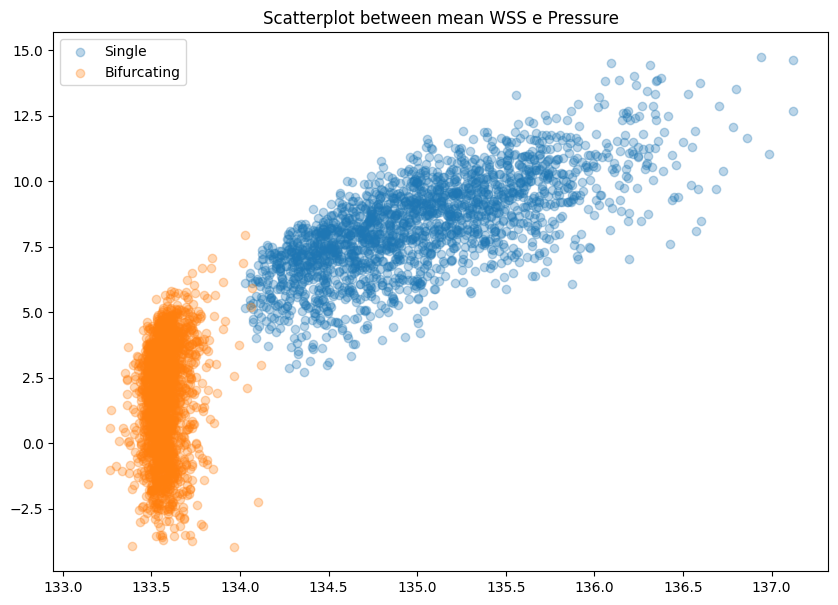

In [36]:
scatter_plot()

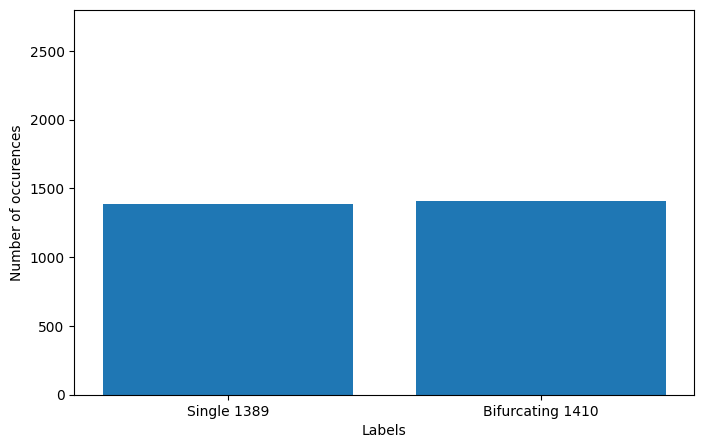

In [37]:
data_module_prove = DataModule(global_variables['single_path'], global_variables['bifurcating_path'])

data_module_prove.prepare_data()
data_module_prove.setup(stage="fit")
train_dataloader = data_module_prove.train_dataloader()
check_balancing(data_module_prove.train_dataset)

# Baseline MLP architecture

To have a baseline to compare the results of the GATr against, a basic MLP architecture is implemented.


The network is composed by a feature extraction block, in which mulitple convolutional layers are used to increase the number of features from 10 to 64 and by a fully connected block.



## Data preparation

First, the data is pre-processed. Each sample is processed separately: the maximum number of points considered for each sample is defined by global_variables['length_data'], the features $\texttt{pos}$, $\texttt{wss}$ and $\texttt{pressure}$ are thus standardized as:
 $$ std(x) = \frac{x - \bar{x}}{\sigma(x)}, $$ where $\bar{x}$ and $\sigma(x)$ represent the mean and standard deviation of feature variable $x$ over all the points of the sample. The feature $\texttt{inlet_idcs}$ was deliberately left out as was considered marginal compared to the other features: as it is shown in the scatter plot between mean $\texttt{wss}$ and $\texttt{pressure}$, the data appears to be well separated even without the $\texttt{inlet_idcs}$ feature. The standardized data is thus concatenated in a torch tensor of size $\texttt{[1, global_variables['length_data'], 10]}$, for each sample.

In [38]:
# Preparation of the data for the MLP architecture
def prepare_data_MLP(sample_path):
  """
  Embeds the artery sample into a concatenation of 4 16-dimensional multivectors in G_{3,0,1}.
  Each of the 4 multivectors embeds a different feature of the artery: pos, face, wss, pressure
  The data is standardized before the embedding
  Input:
    sample_path: path to the artery sample saved in hdf5 format
  Output:
    sample_embedding: torch.Tensor of size (1, length_data, 4, 16)
        where length_data is the number of points in the samples considered for the embedding
  """

  with h5py.File(sample_path, 'r') as f:
    # extract torch tensor for pos
    pos_data = f['pos'][:global_variables['length_data']]
    pos_torch = torch.tensor(pos_data[:])
    pos_torch_norm = (pos_torch - torch.mean(pos_torch)) / torch.std(pos_torch)

    # extract torch tensor for face
    face_data = f['face'][:global_variables['length_data']]
    face_torch = torch.tensor(face_data[:])

    # extract torch tensor for wss
    wss_data = f['wss'][:global_variables['length_data']]
    wss_torch = torch.tensor(wss_data[:])
    wss_torch_norm = (wss_torch - torch.mean(wss_torch)) / torch.std(wss_torch)

    # extract torch tensor for pressure
    pressure_data = f['pressure'][:global_variables['length_data']]
    pressure_torch = torch.tensor(pressure_data[:])
    pressure_torch_norm = (pressure_torch - torch.mean(pressure_torch)) / torch.std(pressure_torch)
    pressure_torch_norm = pressure_torch_norm.unsqueeze(1)

    data_sample = torch.cat([pos_torch_norm, face_torch, pressure_torch_norm, wss_torch_norm], dim = 1)
    data_sample = data_sample.unsqueeze(0)

  return data_sample

## Baseline architecture

In [39]:
class baseline_MLP(nn.Module):
    def __init__(self, num_points, input_dim, num_classes, dropout):
        super(baseline_MLP, self).__init__()

        # Feature extraction block
        self.convolutional_block = nn.Sequential(
            nn.Conv1d(num_points, 16, 1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Conv1d(16, 32, 1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(32, 64, 1),
            nn.BatchNorm1d(64),
            nn.AdaptiveMaxPool1d(1)
        )

        # Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Linear(64, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(16, 8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(8, num_classes-1),
            nn.Sigmoid()
        )

    def forward(self, x):
        #print("Input shape:", x.shape)
        #n_pts = x.size()[2]
        x = self.convolutional_block(x)
        #print("Input shape after input transform:", x.shape)
        x = x.max(dim=-1, keepdim=True)[0]
        #print("Input shape after max:", x.shape)
        x = x.view(-1, 64)
        #print("Input shape after .view:", x.shape)
        x = self.fc(x)
        #print("Input shape after fc:", x.shape)

        return x.view(-1)

In [40]:
# Creation of a Pytorch Lightning module for the MLP architecture
class baseline_MLP_PL(pl.LightningModule):
  """
  Pytorch Lignthing class for the baseline transformer
  """
  def __init__(self, num_points, input_dim, num_classes, dropout, patience, factor, lr = 1e-3):
    super(baseline_MLP_PL, self).__init__()

    self.model = baseline_MLP(
    num_points,
    input_dim,
    num_classes,
    dropout
  ).to(device)

    self.lr = lr
    self.patience = patience
    self.factor = factor

    self.criterion = nn.BCELoss()

    self.accuracy = BinaryAccuracy()
    self.precision = BinaryPrecision()
    self.recall = BinaryRecall()
    self.f1 = BinaryF1Score()


  def forward(self, x):
    x = x.to(device)
    return self.model(x)

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=self.patience, factor=self.factor)
    return optimizer

  def training_step(self, batch):
    input, label = batch

    input = input.to(device)

    outputs = self.model(input)
    logits = torch.sigmoid(outputs)
    loss = self.criterion(logits, label.float())
    self.log("train_loss", loss)
    print("train_loss", loss)
    train_losses.append(loss.cpu().detach().numpy())

    return loss

  def validation_step(self, batch):
    input, label = batch

    input = input.to(device)

    outputs = self.model(input)
    logits = torch.sigmoid(outputs)

    loss = self.criterion(logits, label.float())

    acc = self.accuracy(outputs, label)
    output_values = {"val_loss": loss, "val_acc" : acc}
    self.log_dict(output_values)
    return loss

  def test_step(self, batch):
    input, label = batch

    input = input.to(device)

    outputs = self.model(input)
    logits = torch.sigmoid(outputs)
    loss = self.criterion(logits, label.float())
    acc = self.accuracy(outputs, label)
    precision = self.precision(outputs, label)
    recall = self.recall(outputs, label)
    f1 = self.f1(outputs, label)


    output_values = {"test_loss": loss, "test_acc" : acc, "test_precision" : precision, "test_recall" : recall, "test_f1" : f1}
    self.log_dict(output_values)
    return loss

  def predict_step(self, batch):
    input, label = batch

    input = input.to(device)

    predicted = self.model(input)
    predicted_label = torch.round(predicted)
    t_label.append(label.cpu().detach())
    p_label.append(predicted_label.cpu().detach())

    return predicted_label

## Training of the model

First, the DataModuleMLP class is instantiated. The Pytorch Module is thus set up for training.

The input and output dimensions are checked to verify the correctness of the model.

In [41]:
# Training
train_losses = []

mlp_data_module = DataModule(
        global_variables['single_path'],
        global_variables['bifurcating_path'],
        baseline = True
    )

model = baseline_MLP_PL(
        global_variables['length_data'],
        global_variables['dim_input_MLP'],
        global_variables['num_classes'],
        dropout = global_variables['dropout'],
        patience = global_variables['patience'],
        factor = global_variables['factor']
    )

max_epochs_mlp = 5
trainer = pl.Trainer(max_epochs = max_epochs_mlp)

start_time = time.time()
trainer.fit(model, mlp_data_module)
end_time = time.time()

# Total training time:
training_time_MLP = end_time - start_time
print(f"Training time MLP: {training_time_MLP:.2f} seconds")

training_time_epoch_MLP = training_time_MLP/max_epochs_mlp
print(f"Training time per epoch MLP: {training_time_epoch_MLP:.2f} seconds")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type            | Params
----------------------------------------------
0 | model     | baseline_MLP    | 4.9 K 
1 | criterion | BCELoss         | 0     
2 | accuracy  | BinaryAccuracy  | 0     
3 | precision | BinaryPrecision | 0     
4 | recall    | BinaryRecall    | 0     
5 | f1        | BinaryF1Score   | 0     
----------------------------------------------
4.9 K     Trainable params
0         Non-trainable params
4.9 K     Total params
0.020     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (44) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.7470, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


train_loss tensor(0.7051, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6999, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6718, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6836, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6885, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6937, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.7080, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.7404, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6845, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6588, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6691, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.6351, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6450, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6219, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6510, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6663, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6278, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6618, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.5799, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6607, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

Validation: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.6280, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6642, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6107, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6095, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.5861, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6042, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6620, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6157, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

Validation: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.6278, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.5737, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6295, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6067, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.5891, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.5735, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6426, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6260, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6046, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.5925, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.5972, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

Validation: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.5942, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.5991, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6305, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6105, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.5844, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6028, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.5822, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6076, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.5828, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.5880, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.5613, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Training time MLP: 22.29 seconds
Training time per epoch MLP: 4.46 seconds


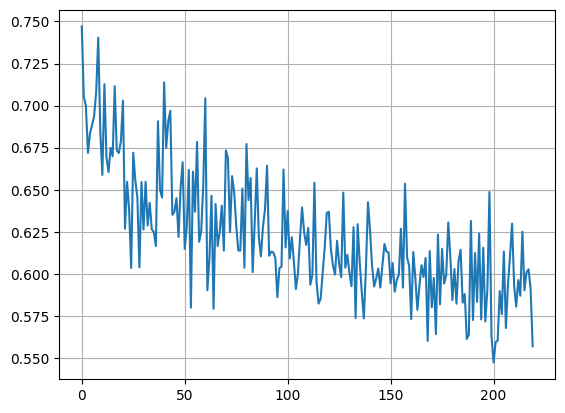

In [42]:
show_graph(train_losses)

## Test:

In [43]:
# Test metrics:
start_time = time.time()
trainer.test(model, mlp_data_module)
end_time = time.time()

inference_time_MLP = end_time - start_time
print("inference time MLP: ", inference_time_MLP, "s")

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9900249242782593     │
│          test_f1          │    0.9895302653312683     │
│         test_loss         │    0.5761097073554993     │
│      test_precision       │            1.0            │
│        test_recall        │    0.9795672297477722     │
└───────────────────────────┴───────────────────────────┘

inference time MLP:  7.062892436981201 s


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

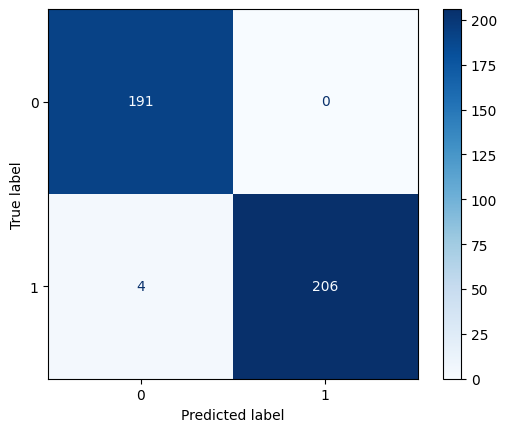

In [44]:
t_label = []
p_label = []
trainer.predict(model, mlp_data_module)

confusion_matrix_display(torch.cat(t_label), torch.cat(p_label))

# Baseline Transformer

In this section we defined the transformer baseline model as specified in the paper [5]. The task is a classification task so we implemented and used only the encoder part using the hyperparameter defined in the section global variables.
We implemented the following blocks:

*   Input embedding layer (fully connected)
*   Multi - Head attention block
*   Ecoder layer composed by:
      - Multi - Head attention layer    
      - Layer Norm
      - Feedforward layer
      - Layer Norm
*   2 x fully connected layers used for classification

We also implemented the pytorch lightning class in order to train and test it using pytorch lightning.

The aim of this baseline is to measure the performances of this model and compare them to the performances of the SOTA model.



<center>
    <img src="https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1.png"  height="600">
</center>

##MultiHeadAttention

In [45]:
class MultiHeadAttention(nn.Module):
  """
  Multi-head attention module for the baseline transformer
  """
  def __init__(self, hidden_dim, num_heads, dropout=0.1):
      super(MultiHeadAttention, self).__init__()
      assert hidden_dim % num_heads == 0, "emb_dim must be divisible by num_heads"

      self.hidden_dim = hidden_dim
      self.num_heads = num_heads
      self.head_dim = hidden_dim // num_heads

      self.query = nn.Linear(self.head_dim, self.head_dim)
      self.key = nn.Linear(self.head_dim, self.head_dim)
      self.value = nn.Linear(self.head_dim, self.head_dim)

  def forward(self, x):

      x = x.view(x.shape[0], x.shape[1], self.num_heads, self.head_dim).transpose( 1, 2 )

      q = self.query(x)
      k = self.key(x)
      v = self.value(x)

      att = self.att_score(q, k, v)

      out = att.transpose(1, 2).reshape(x.shape[0], x.shape[2], self.hidden_dim)

      return out

  def att_score(self, q, k, v):
      attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)

      attn_probs = torch.softmax(attn_scores, dim=-1)
      output = torch.matmul(attn_probs, v)
      return output


##Encoder

In [46]:
class Encoder(nn.Module):
  """
  Encoder module for the baseline transformer
  """
  def __init__(self, input_dim, hidden_dim, num_heads, dropout = 0.1):
    super(Encoder, self).__init__()

    self.multi_head_attention = MultiHeadAttention(hidden_dim, num_heads)

    self.feedforward = nn.Sequential(
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim)
    )

    self.layer_norm1 = nn.LayerNorm(hidden_dim)
    self.layer_norm2 = nn.LayerNorm(hidden_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):

    att = self.multi_head_attention(x)

    norm = self.layer_norm1( x + self.dropout(att))

    ff = self.feedforward(norm)

    out = self.layer_norm2( norm + self.dropout(ff))

    return out

##Transformer

In [47]:
class Transformer(nn.Module):
  """
  Entire baseline transformer
  """
  def __init__(self, input_dim, channels, hidden_dim, num_heads, out_channels, number_of_samples, number_of_classes, dropout = 0.1):
    super(Transformer, self).__init__()

    self.input_dim = input_dim
    self.channels = channels

    self.input_embedding = nn.Sequential(
        nn.Linear(input_dim * channels, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim)
    )

    self.ff_layer1 = nn.Linear(hidden_dim, out_channels)
    self.relu = nn.ReLU()
    self.ff_layer2 = nn.Linear(number_of_samples, number_of_classes - 1)

    self.encoder = Encoder(input_dim, hidden_dim, num_heads, dropout)

    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = x.reshape(x.shape[0], x.shape[1], x.shape[2]* x.shape[3])

    x = self.input_embedding(x)

    x = self.encoder(x)

    x = self.ff_layer1(x)
    x = self.relu(x)
    x = x.squeeze()

    x = self.ff_layer2(x)

    return self.sigmoid(x).squeeze()

##Transformer Pytorch Ligthning

In [48]:
class TransformerPL(pl.LightningModule):
  """
  Pytorch Lignthing class for the baseline transformer
  """
  def __init__(self, input_dim, channels, hidden_dim, num_heads, out_dim, number_of_samples, number_of_classes, dropout = 0.1, lr=1e-3, patience=3, factor = 0.1):
    super(TransformerPL, self).__init__()

    self.transformer = Transformer(
        input_dim,
        channels,
        hidden_dim,
        num_heads,
        out_dim,
        number_of_samples,
        number_of_classes,
        dropout,
    ).to(device)

    self.lr = lr
    self.patience = patience
    self.factor = factor

    self.criterion = nn.BCELoss()

    self.accuracy = BinaryAccuracy()
    self.precision = BinaryPrecision()
    self.recall = BinaryRecall()
    self.f1 = BinaryF1Score()

  def forward(self, x):
    x = x.to(device)
    return self.transformer(x)

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=self.patience, factor=self.factor)
    return optimizer

  def training_step(self, batch):
    input, label = batch

    input = input.to(device)

    outputs = self.transformer(input)
    loss = self.criterion(outputs, label.float())
    self.log("train_loss", loss)
    print("train_loss", loss)
    train_losses.append(loss.cpu().detach().numpy())

    return loss

  def validation_step(self, batch):
    input, label = batch

    input = input.to(device)

    outputs = self.transformer(input)
    loss = self.criterion(outputs, label.float())

    acc = self.accuracy(outputs, label)
    output_values = {"val_loss": loss, "val_acc" : acc}
    self.log_dict(output_values)
    return loss

  def test_step(self, batch):
    input, label = batch

    input = input.to(device)

    outputs = self.transformer(input)
    loss = self.criterion(outputs, label.float())
    acc = self.accuracy(outputs, label)
    precision = self.precision(outputs, label)
    recall = self.recall(outputs, label)
    f1 = self.f1(outputs, label)

    output_values = {"test_loss": loss, "test_acc" : acc, "test_precision" : precision, "test_recall" : recall, "test_f1" : f1}
    self.log_dict(output_values)
    return loss

  def predict_step(self, batch):
    input, label = batch

    input = input.to(device)

    predicted = self.transformer(input)
    predicted_label = torch.round(predicted)
    t_label.append(label.cpu().detach())
    p_label.append(predicted_label.cpu().detach())

    return predicted_label

##Train

In [49]:
train_losses = []

transformer_data_module = DataModule(
        global_variables['single_path'],
        global_variables['bifurcating_path']
    )

transformer = TransformerPL(
        global_variables['mv_dimension'],
        global_variables['mv_channels'],
        global_variables['hidden_dim_mv'],
        global_variables['num_heads'],
        global_variables['out_channels'],
        global_variables['length_data'],
        global_variables['num_classes'],
        dropout = global_variables['dropout'],
        patience = global_variables['patience'],
        factor = global_variables['factor'],
    ).to(device)

In [50]:
max_epochs_transformer = 10
trainer = pl.Trainer(max_epochs = max_epochs_transformer)

start_time = time.time()
trainer.fit(transformer, transformer_data_module)
end_time = time.time()

# Total training time transformer:
training_time_transformer = end_time - start_time
print(f"Training time transformer: {training_time_transformer:.2f} seconds")

training_time_epoch_transformer = training_time_transformer/max_epochs_transformer
print(f"Training time per epoch transformer: {training_time_epoch_transformer:.2f} seconds")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type            | Params
------------------------------------------------
0 | transformer | Transformer     | 888   
1 | criterion   | BCELoss         | 0     
2 | accuracy    | BinaryAccuracy  | 0     
3 | precision   | BinaryPrecision | 0     
4 | recall      | BinaryRecall    | 0     
5 | f1          | BinaryF1Score   | 0     
------------------------------------------------
888       Trainable params
0         Non-trainable params
888       Total params
0.004     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (44) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.6884, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6921, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6998, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6919, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6946, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6910, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6929, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6978, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6983, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6857, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6921, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6925, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.6284, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6162, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6227, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6168, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.6011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.5890, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.5920, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.5916, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.5755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.5552, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.5622, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

Validation: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.3124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3507, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2888, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3200, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3520, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3814, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3335, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3349, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3115, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3836, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3667, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

Validation: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.3130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3345, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3701, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3534, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3089, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3113, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3558, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3270, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3443, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2217, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2186, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

Validation: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.2745, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2647, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3272, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2965, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2897, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3113, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2460, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2824, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2774, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2585, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2792, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

Validation: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.3085, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2720, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2798, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2711, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2556, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3281, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2495, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3449, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2293, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2702, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3043, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2952, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

Validation: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.2318, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2620, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2555, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2777, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3051, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2520, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3208, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2096, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1975, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2961, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2260, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3095, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

Validation: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.2038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2502, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2203, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2682, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2273, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2919, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2521, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.3076, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2747, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2849, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2261, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2822, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

Validation: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.2358, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2446, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1893, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2037, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2192, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2893, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2445, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1721, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2729, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1796, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2181, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

Validation: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.2362, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2731, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1970, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2662, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2725, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2642, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2796, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2414, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2343, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1806, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Training time transformer: 19.68 seconds
Training time per epoch transformer: 1.97 seconds


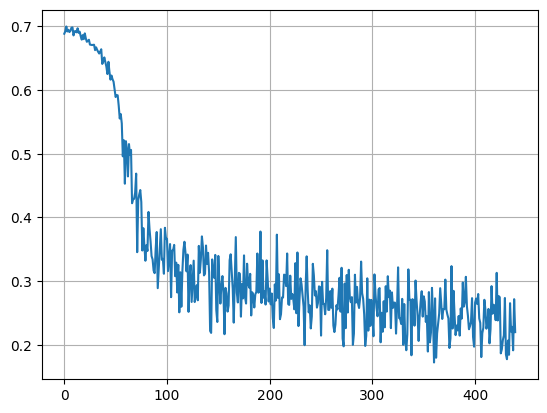

In [51]:
show_graph(train_losses)

##Testing

In [52]:
start_time = time.time()
trainer.test(transformer, transformer_data_module)
end_time = time.time()

# Total training time:
inference_time_transformer = end_time - start_time
print(f"Inference time transformer: {inference_time_transformer:.2f} seconds")

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │            1.0            │
│          test_f1          │            1.0            │
│         test_loss         │    0.2446948140859604     │
│      test_precision       │            1.0            │
│        test_recall        │            1.0            │
└───────────────────────────┴───────────────────────────┘

Inference time transformer: 8.24 seconds


##Predict

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

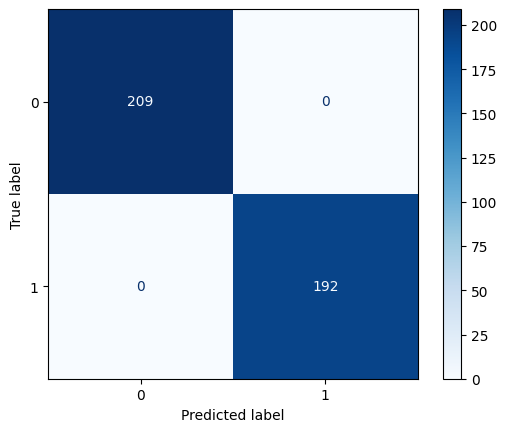

In [53]:
t_label = []
p_label = []

trainer.predict(transformer, transformer_data_module)


confusion_matrix_display(torch.cat(t_label), torch.cat(p_label))

#Geometric Algebra Transformer (GATr)

The basic components of the Geometric Algebra Transformer are now defined, and in particular:

*   Equilinear Layer
*   Equilinear Layer Norm
*   Geometric attention
*   Gated GELU
*   Geometric Bilinear Layer





##Equilinear Layer

In [54]:
class EquiLinearLayer(nn.Module):
    """
    This class defines the Equilinear Layer using blades
    """
    def __init__(self, input_mv_channels, hidden_mv_dim, blade, blade_len):
        super(EquiLinearLayer,self).__init__()

        self.weights = nn.Parameter(
            torch.empty(hidden_mv_dim, input_mv_channels, blade_len).to(device)
        )
        self.initialize_weights()

        self.blades = blade
        self.blade_len = blade_len

    def initialize_weights(self):
        torch.nn.init.xavier_uniform_(self.weights)

    def forward(self,x):
        output_mv = torch.einsum(
            #h: hidden_mv_dim
            #i: input_mv_channels
            #b: blade_len
            #r: blade_rows
            #c: blade_cols

            "h i b, b r c, ... i r -> ... h c",
            self.weights,
            self.blades,
            x
         )
        return output_mv

##Equilayer Normalization

In [55]:
class EquilayerNorm(nn.Module):
  """
  This class defines the Normalized Equilinear Layer
  """
  def __init__(self):
    super(EquilayerNorm,self).__init__()

  def forward(self, x):

    outputs = x / torch.sqrt(torch.mean(inner_product(x, x), dim=-2, keepdim=True))

    return outputs

##Geometric Attention

In [56]:
class Geometric_Multihead_Attention(nn.Module):
  """
  Geometric multi-head attention module for GATr
  """
  def __init__(self, hidden_dim, input_mv_dim, blades, num_heads, out_dim):
    super(Geometric_Multihead_Attention, self).__init__()

    assert hidden_dim % num_heads == 0, "emb_dim must be divisible by num_heads"

    self.hidden_dim = hidden_dim
    self.num_heads = num_heads

    self.query =  EquiLinearLayer(
                        input_mv_channels = input_mv_dim,
                        hidden_mv_dim = hidden_dim * num_heads,
                        blade = blades,
                        blade_len = blades.shape[0]
                    )

    self.key =  EquiLinearLayer(
                        input_mv_channels = input_mv_dim,
                        hidden_mv_dim = hidden_dim ,
                        blade = blades,
                        blade_len = blades.shape[0]
                    )

    self.value =  EquiLinearLayer(
                        input_mv_channels = input_mv_dim,
                        hidden_mv_dim = hidden_dim ,
                        blade = blades,
                        blade_len = blades.shape[0]
                    )

    self.output_layer =  EquiLinearLayer(
                        input_mv_channels = hidden_dim * num_heads,
                        hidden_mv_dim = out_dim,
                        blade = blades,
                        blade_len = blades.shape[0]
                    )

  def forward(self, x):
    q = self.query(x)
    k = self.key(x)
    v = self.value(x)

    batch_size, items, embed_dim, multivector = q.size()

    #split heads
    q = q.view(batch_size, items, self.hidden_dim, self.num_heads, multivector).transpose(3,2).transpose(2,1)
    k = k.view(batch_size, items, self.hidden_dim, 1, multivector).transpose(3,2).transpose(2,1)
    v = v.view(batch_size, items, self.hidden_dim, 1, multivector).transpose(3,2).transpose(2,1)

    """mask = get_mask_product().int().to(device)

    q = q * mask
    k = k * mask
    v = v"""
    att = self.attention_score(q, k, v) #torch.Size([32, 4, 100, 64, 16])
    att = rearrange( att, "... heads items hidden_dim x -> ... items (heads hidden_dim) x" )

    output = self.output_layer(att)

    return output

  def attention_score(self, q, k, v):

    att_score = inner_product(q, k) / math.sqrt(8 * self.hidden_dim)

    att_score = torch.softmax(att_score, dim = 2)

    att_score = att_score* v

    return att_score

##Gated GeLU

In [57]:
class GatedGeLU(nn.Module):
  """
  Gated GELU module for GATr
  """
  def __init__(self):
    super(GatedGeLU, self).__init__()

    self.GeLU = GELU()

  def forward(self, x):

    x1 = x[..., 0]
    output = self.GeLU(x1)

    return output.unsqueeze(-1) * x



##Geometric Bilinear Layer

In [58]:
class GeometricBilinearLayer(nn.Module):
  """
  Geometric Bilinear Layer module for GATr
  """
  def __init__(self, in_channels, out_channels, blades):
    super(GeometricBilinearLayer, self).__init__()

    self.input_1 = EquiLinearLayer(
                        input_mv_channels = in_channels,
                        hidden_mv_dim = out_channels // 2,
                        blade = blades,
                        blade_len = blades.shape[0]
                    )

    self.input_2 = EquiLinearLayer(
                        input_mv_channels = in_channels,
                        hidden_mv_dim = out_channels // 2,
                        blade = blades,
                        blade_len = blades.shape[0]
                    )

  def forward(self, x):

    input_1 = self.input_1(x)
    input_2 = self.input_2(x)

    geometric_prod = geometric_product(input_1, input_2).to(device)

    z = torch.mean(x, dim = (1,2), keepdim = True)

    equijoin = z[...,-1].unsqueeze(-1) * join_operation(input_1, input_2)

    equijoin = equijoin.to(device)

    return torch.cat((geometric_prod* 1e-5, equijoin) , dim = -2)


##Geometric Encoder

<center>

![Baseline](https://media.licdn.com/dms/image/D4D22AQGX9zX1vw6QIQ/feedshare-shrink_800/0/1693985295396?e=2147483647&v=beta&t=koYJ91QwdwtqrDytXvepUhck7BrkJDU-f-aGpjiywTc)

</center>

The GATr architecture is composed by an initial equilinear layer, an encoder (enclosed in the gray box in the image above) and a final equilinear layer. The Encoder is defined in the GeometricEncoder class, while the entire architecture is defined in GATr class.

In [59]:
class GeometricEncoder(nn.Module):
  """
  Geometric Encoder for GATr
  """
  def __init__(self, hidden_dim, input_mv_dim, blades, num_heads, out_dim , dropout=0.1):
    super(GeometricEncoder, self).__init__()

    self.equilinear_layer2 =  EquiLinearLayer(
        input_mv_channels = hidden_dim,
        hidden_mv_dim = hidden_dim,
        blade = blades,
        blade_len = blades.shape[0]
    )

    self.equi_layer_norm1 = EquilayerNorm()

    self.geometric_attention = Geometric_Multihead_Attention(hidden_dim, hidden_dim, blades, num_heads, out_dim)

    self.equi_layer_norm2 = EquilayerNorm()

    self.geometric_bilinear = GeometricBilinearLayer(out_dim, hidden_dim, blades)

    self.gated_gelu = GatedGeLU()

    self.out_equilinear =  EquiLinearLayer(
        input_mv_channels = hidden_dim,
        hidden_mv_dim = hidden_dim,
        blade = blades,
        blade_len = blades.shape[0]
    )

    self.dropout = nn.Dropout(dropout)

  def forward(self, x):

    equi_layer1 = self.equi_layer_norm1(x)

    equi_lin2 = self.equilinear_layer2(equi_layer1)

    geom_attn = self.geometric_attention(equi_lin2)

    res_1 = x + self.dropout(geom_attn)

    equi_layer2 = self.equi_layer_norm2(res_1)

    geom_bil = self.geometric_bilinear(equi_layer2)

    gated_out = self.gated_gelu(geom_bil)

    out_equi = self.out_equilinear(gated_out)

    res_2 = res_1 + self.dropout(out_equi)

    return res_2

## GATr

In [60]:
class GATr(nn.Module):
    """
    This class defines the entire architecture of the geometric transformer
    """
    def __init__(self, hidden_dim, channels, blades, num_heads, number_of_samples, number_of_classes, dropout = 0.1):
      super(GATr, self).__init__()

      self.equilinear_layer1 =  EquiLinearLayer(
          input_mv_channels = channels,
          hidden_mv_dim = hidden_dim,
          blade = blades,
          blade_len = blades.shape[0]
      ).to(device)

      self.encoder = GeometricEncoder(hidden_dim, channels, blades, num_heads, hidden_dim, dropout=dropout).to(device)

      self.out_equilinear =  EquiLinearLayer(
          input_mv_channels = hidden_dim,
          hidden_mv_dim = number_of_classes - 1,
          blade = blades,
          blade_len = blades.shape[0]
      ).to(device)

      self.sigmoid = nn.Sigmoid()

      self.linear = nn.Linear(global_variables['mv_dimension'], number_of_classes - 1).to(device)

      self.relu = nn.ReLU().to(device)

      self.linear2 = nn.Linear(global_variables['length_data'], number_of_classes - 1).to(device)

    def forward(self, x):

      x =  self.equilinear_layer1(x)

      enc_out = self.encoder(x)

      equi_output = self.out_equilinear(enc_out).squeeze()

      l1 = self.linear(equi_output).squeeze()
      re = self.relu(l1)
      l2 = self.linear2(re).squeeze()

      return self.sigmoid(l2)

##GATr Pytorch Lightning Module

In [61]:
class GATrPL(pl.LightningModule):
  """
  This class defines the pytorch lightning framework for GATr
  """
  def __init__(self, hidden_dim, channels, num_heads, number_of_samples, number_of_classes, blades, lr=1e-3, patience=3, factor = 0.1, dropout = 0.1):
    super(GATrPL, self).__init__()

    self.blades = blades
    self.dropout = dropout

    self.gatr = GATr(
        hidden_dim,
        channels,
        self.blades,
        num_heads,
        number_of_samples,
        number_of_classes,
        dropout = self.dropout
    ).to(device)

    self.lr = lr
    self.patience = patience
    self.factor = factor
    self.criterion = nn.BCELoss()
    self.accuracy = BinaryAccuracy()
    self.precision = BinaryPrecision()
    self.recall = BinaryRecall()
    self.f1 = BinaryF1Score()

  def forward(self, x):
    x = x.to(device)
    return self.gatr(x)

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=self.patience, factor=self.factor)
    return optimizer

  def training_step(self, batch):
    input, label = batch

    input = input.to(device)

    outputs = self.gatr(input)
    loss = self.criterion(outputs, label.float())
    self.log("train_loss", loss)
    print("train_loss", loss)
    train_losses.append(loss.cpu().detach().numpy())

    return loss

  def validation_step(self, batch):
    input, label = batch

    input = input.to(device)
    outputs = self.gatr(input)
    loss = self.criterion(outputs, label.float())
    acc = self.accuracy(outputs, label)
    output_values = {"val_loss": loss, "val_acc" : acc}
    self.log_dict(output_values)
    return loss

  def test_step(self, batch):
    input, label = batch

    input = input.to(device)
    outputs = self.gatr(input)
    loss = self.criterion(outputs, label.float())
    acc = self.accuracy(outputs, label)
    precision = self.precision(outputs, label)
    recall = self.recall(outputs, label)
    f1 = self.f1(outputs, label)

    output_values = {"test_loss": loss, "test_acc" : acc, "test_precision" : precision, "test_recall" : recall, "test_f1" : f1}
    self.log_dict(output_values)
    return loss

  def predict_step(self, batch):
    input, label = batch

    input = input.to(device)

    predicted = self.gatr(input)

    predicted_label = torch.round(predicted)
    t_label.append(label.cpu().detach())
    p_label.append(predicted_label.cpu().detach())

    return predicted_label


##Training

In [62]:
# training of GATr on the training dataset
train_losses = []

gatr_data_module = DataModule(
        global_variables['single_path'],
        global_variables['bifurcating_path']
    )

mv_ones = torch.ones(global_variables['dim_GA'])

# extraction of the blades
blades_values = extract_blades(mv_ones, layout)
blades = blade_matrices(blades_values).to(device)

gatr = GATrPL(
        global_variables['hidden_dim_mv'],
        global_variables['mv_channels'],
        global_variables['num_heads'],
        global_variables['length_data'],
        global_variables['num_classes'],
        blades,
        patience = global_variables['patience'],
        factor = global_variables['factor'],
        dropout = global_variables['dropout'],
    )


/usr/local/lib/python3.10/dist-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


In [77]:
max_epochs = 15
trainer = pl.Trainer(max_epochs = max_epochs)

start_time = time.time()
trainer.fit(gatr, gatr_data_module)
end_time = time.time()

# Total training time:
training_time_gatr = end_time - start_time
print(f"Training time gatr: {training_time_gatr:.2f} seconds")

training_time_epoch_gatr = training_time_gatr/max_epochs
print(f"Mean training time per epoch gatr: {training_time_epoch_gatr:.2f} seconds")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type            | Params
----------------------------------------------
0 | gatr      | GATr            | 5.6 K 
1 | criterion | BCELoss         | 0     
2 | accuracy  | BinaryAccuracy  | 0     
3 | precision | BinaryPrecision | 0     
4 | recall    | BinaryRecall    | 0     
5 | f1        | BinaryF1Score   | 0     
----------------------------------------------
5.6 K     Trainable params
0         Non-trainable params
5.6 K     Total params
0.022     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (44) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.1472, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0555, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0774, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1556, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0720, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0897, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0970, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0898, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1726, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0924, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0640, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1424, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.0867, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1328, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0953, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0914, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1276, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0262, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1393, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1014, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1274, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0916, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0601, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0821, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

Validation: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.0629, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0875, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0779, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1036, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0659, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2286, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0257, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0609, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0848, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0428, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0573, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1175, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

Validation: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.0516, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0995, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0964, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0405, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1601, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0313, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0807, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0707, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0553, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

Validation: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.0647, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2071, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0395, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0541, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1472, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0430, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1342, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0864, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0720, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0312, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0300, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0918, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

Validation: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.0672, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0820, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0894, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0285, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0363, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1211, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0466, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0693, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

Validation: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.0706, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0169, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0531, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1486, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0273, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0617, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0680, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0987, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1405, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0640, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1363, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1254, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

Validation: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.0521, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0854, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0234, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0975, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0579, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0288, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0522, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0750, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1526, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1265, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0955, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0533, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

Validation: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.1112, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0420, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0470, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1177, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0241, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0394, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0715, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0815, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.2066, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0930, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

Validation: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.0452, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0891, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0159, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0510, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0971, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0819, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0857, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0509, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0204, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0348, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0349, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

Validation: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.0268, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0655, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0463, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0535, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0536, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0678, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0445, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1403, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0833, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0818, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0482, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

Validation: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.0145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0936, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0587, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0707, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0462, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0667, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0340, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0313, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0558, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1530, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0448, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0174, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

Validation: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.0690, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0267, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1455, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0303, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1698, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0343, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0277, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0332, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0313, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0318, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0446, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0684, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

Validation: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.0425, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0744, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0276, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0572, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0862, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0600, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0300, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0395, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0472, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0893, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0261, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

Validation: |          | 0/? [00:00<?, ?it/s]

train_loss tensor(0.0665, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0965, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.1377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0266, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0577, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0328, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0436, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0812, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0893, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tensor(0.0050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
train_loss tenso

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


Training time gatr: 60.66 seconds
Mean training time per epoch gatr: 4.04 seconds


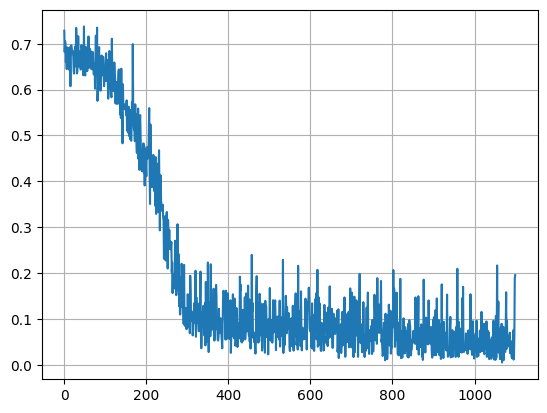

In [78]:
show_graph(train_losses)

##Testing

In [79]:
# Test metrics:
start_time = time.time()
trainer.test(gatr, gatr_data_module)
end_time = time.time()

inference_time_gatr = end_time - start_time
print(f"Inference time gatr: {inference_time_gatr:.2f} seconds")

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9900249242782593     │
│          test_f1          │     0.988585352897644     │
│         test_loss         │    0.03100665844976902    │
│      test_precision       │     0.994088888168335     │
│        test_recall        │    0.9834488034248352     │
└───────────────────────────┴───────────────────────────┘

Inference time gatr: 7.89 seconds


##Predict

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

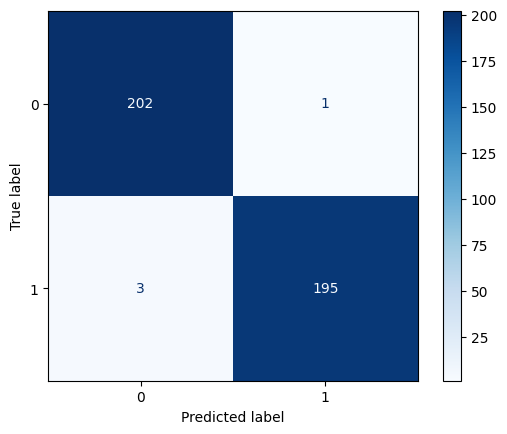

In [80]:
t_label = []
p_label = []
trainer.predict(gatr, gatr_data_module)

confusion_matrix_display(torch.cat(t_label), torch.cat(p_label))

In [81]:
# Summary training and inference time:

print(f"Training time MLP: {training_time_MLP:.2f} seconds")
print(f"Training time per epoch MLP: {training_time_epoch_MLP:.2f} seconds")
print(f"Inference time MLP: {inference_time_MLP:.2f} seconds")
print("-------------------------------------")
print(f"Training time transformer: {training_time_transformer:.2f} seconds")
print(f"Training time per epoch transformer: {training_time_epoch_transformer:.2f} seconds")
print(f"Inference time transformer: {inference_time_transformer:.2f} seconds")
print("-------------------------------------")
print(f"Training time gatr: {training_time_gatr:.2f} seconds")
print(f"Training time per epoch gatr: {training_time_epoch_gatr:.2f} seconds")
print(f"Inference time gatr: {inference_time_gatr:.2f} seconds")

Training time MLP: 22.29 seconds
Training time per epoch MLP: 4.46 seconds
Inference time MLP: 7.06 seconds
-------------------------------------
Training time transformer: 19.68 seconds
Training time per epoch transformer: 1.97 seconds
Inference time transformer: 8.24 seconds
-------------------------------------
Training time gatr: 60.66 seconds
Training time per epoch gatr: 4.04 seconds
Inference time gatr: 7.89 seconds


#Equivariant Check

In [82]:
def equivariance_check_plane_reflection(mv, layer, mul_factor):
    # plane reflection
    # extract a random normal vector
    random_vector = torch.randn(3)
    norm = random_vector.norm(p=2)
    normal = (random_vector / norm).to(device)

    # extract a random shift between -1 and 1
    shift = torch.empty(1).uniform_(-0.5, 0.5).item() * mul_factor
    operator, inv_operator = embed_plane_reflection_mv_16(normal,shift)
    mv , indices = grade_involution(mv)

    operator = operator.to(device)
    inv_operator = inv_operator.to(device)
    input = layer(sandwich_product(mv , operator, inv_operator))
    output = sandwich_product(layer(mv) , operator, inv_operator)
    return torch.norm( output - input )

In [83]:
def equivariance_check_rotation(mv, layer, mul_factor):

    random_vector = torch.randn(3)
    norm = random_vector.norm(p=2)
    axis = (random_vector / norm).to(device)

    # extract a random angle in -pi, pi
    angle = torch.empty(1).uniform_(-math.pi, math.pi).item() * mul_factor
    operator, inv_operator = embed_quaternion_rotation_mv_16(axis , angle)
    mv , indices = grade_involution(mv)

    operator = operator.to(device)
    inv_operator = inv_operator.to(device)
    input = layer(sandwich_product(mv , operator, inv_operator))
    output = sandwich_product(layer(mv) , operator, inv_operator)
    return torch.norm(output - input )

In [84]:
def equivariance_check_translation(mv, layer , mul_factor):
    # translation
    # extract a random translation vector t
    random_vector = torch.randn(3)
    norm = random_vector.norm(p=2)
    t = (random_vector / norm).to(device) * mul_factor
    operator, inv_operator = embed_translation_mv_16(t)
    mv , indices = grade_involution(mv)

    operator = operator.to(device)
    inv_operator = inv_operator.to(device)

    input = layer(sandwich_product(mv , operator, inv_operator))
    output = sandwich_product(layer(mv) , operator, inv_operator)
    return torch.norm(output - input )

In [85]:
def equivariance_check_point_reflection(mv, layer, mul_factor):
    # point reflection
    # extract a random point
    random_point = torch.randn(3)
    norm = random_point.norm(p=2)
    point = (random_point / norm).to(device) * mul_factor
    operator, inv_operator = embed_point_reflection_mv(point)
    mv , indices = grade_involution(mv)

    operator = operator.to(device)
    inv_operator = inv_operator.to(device)
    input = layer(sandwich_product(mv , operator, inv_operator))
    output = sandwich_product(layer(mv) , operator, inv_operator)
    return torch.norm(output - input )

In [86]:
def extract_layers(model, layers=None):
    layers = {}

    list_of_layer = []

    for name, layer in model.named_children():
        if isinstance(layer, nn.Module):
            list_of_layer.append((name, layer))

    layers['Equilinear'] = list_of_layer[0][1].equilinear_layer1
    layers['Equilayer_norm'] = list_of_layer[0][1].encoder.equi_layer_norm1
    layers['Geometric_attention'] = list_of_layer[0][1].encoder.geometric_attention
    layers['Geometric_Bilinear_Layer'] = list_of_layer[0][1].encoder.geometric_bilinear
    return layers

extract_layers(gatr)

{'Equilinear': EquiLinearLayer(),
 'Equilayer_norm': EquilayerNorm(),
 'Geometric_attention': Geometric_Multihead_Attention(
   (query): EquiLinearLayer()
   (key): EquiLinearLayer()
   (value): EquiLinearLayer()
   (output_layer): EquiLinearLayer()
 ),
 'Geometric_Bilinear_Layer': GeometricBilinearLayer(
   (input_1): EquiLinearLayer()
   (input_2): EquiLinearLayer()
 )}

In [87]:
test_data_module = DataModule(global_variables['single_path'], global_variables['bifurcating_path'])

test_data_module.prepare_data()
test_data_module.setup(stage="test")
train_dataloader = test_data_module.test_dataloader()
test = next(iter(train_dataloader))[0]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [88]:
def equivariant_check(mv, model, mul_factor):
  layers = extract_layers(model)
  bigger_mv = torch.cat([mv, mv], dim=2)

  number_of_elements = mv.shape[0] + mv.shape[1] + mv.shape[2]

  check_plane_reflection = []
  check_rotation = []
  check_translation = []
  check_point_reflection = []

  #plane reflection
  check_plane_reflection.append(equivariance_check_plane_reflection(mv.to(device), layers["Equilinear"].to(device), mul_factor).cpu().detach().numpy()/number_of_elements)
  check_plane_reflection.append(equivariance_check_plane_reflection(mv.to(device), layers["Equilayer_norm"].to(device), mul_factor).cpu().detach().numpy()/number_of_elements)

  check_plane_reflection.append(equivariance_check_plane_reflection(bigger_mv.to(device), layers["Geometric_attention"].to(device), mul_factor).cpu().detach().numpy()/number_of_elements)
  check_plane_reflection.append(equivariance_check_plane_reflection(bigger_mv.to(device), layers["Geometric_Bilinear_Layer"].to(device), mul_factor).cpu().detach().numpy()/number_of_elements)

  #rotation
  check_rotation.append(equivariance_check_rotation(mv.to(device), layers["Equilinear"].to(device), mul_factor).cpu().detach().numpy()/number_of_elements)
  check_rotation.append(equivariance_check_rotation(mv.to(device), layers["Equilayer_norm"].to(device), mul_factor).cpu().detach().numpy()/number_of_elements)

  check_rotation.append(equivariance_check_rotation(bigger_mv.to(device), layers["Geometric_attention"].to(device), mul_factor).cpu().detach().numpy()/number_of_elements)
  check_rotation.append(equivariance_check_rotation(bigger_mv.to(device), layers["Geometric_Bilinear_Layer"].to(device), mul_factor).cpu().detach().numpy()/number_of_elements)

  #translation
  check_translation.append(equivariance_check_translation(mv.to(device), layers["Equilinear"].to(device), mul_factor).cpu().detach().numpy()/number_of_elements)
  check_translation.append(equivariance_check_translation(mv.to(device), layers["Equilayer_norm"].to(device), mul_factor).cpu().detach().numpy()/number_of_elements)

  check_translation.append(equivariance_check_translation(bigger_mv.to(device), layers["Geometric_attention"].to(device), mul_factor).cpu().detach().numpy()/number_of_elements)
  check_translation.append(equivariance_check_translation(bigger_mv.to(device), layers["Geometric_Bilinear_Layer"].to(device), mul_factor).cpu().detach().numpy()/number_of_elements)

  #point reflection
  check_point_reflection.append(equivariance_check_point_reflection(mv.to(device), layers["Equilinear"].to(device), mul_factor).cpu().detach().numpy()/number_of_elements)
  check_point_reflection.append(equivariance_check_point_reflection(mv.to(device), layers["Equilayer_norm"].to(device), mul_factor).cpu().detach().numpy()/number_of_elements)

  check_point_reflection.append(equivariance_check_point_reflection(bigger_mv.to(device), layers["Geometric_attention"].to(device), mul_factor).cpu().detach().numpy()/number_of_elements)
  check_point_reflection.append(equivariance_check_point_reflection(bigger_mv.to(device), layers["Geometric_Bilinear_Layer"].to(device), mul_factor).cpu().detach().numpy()/number_of_elements)

  return check_plane_reflection , check_rotation , check_translation , check_point_reflection

equivariant_check(test, gatr, 0.1)

([3.5214991165419756,
  1.2690396156898006e-07,
  6.871745481329449,
  0.0004831899778317597],
 [1.4996198233911546,
  1.0303142131552874e-07,
  0.5124759674072266,
  5.634158249881308e-05],
 [0.9329420833264367,
  8.479393488676702e-09,
  0.2691969305781995,
  0.000508727663654392],
 [2.5049627271749206,
  9.860395678870036e-09,
  0.7987742666470803,
  0.0024763181553048605])

In [89]:
def show_results(test, gatr, mul_factor):
    check_plane_reflection, check_rotation, check_translation, check_point_reflection = equivariant_check(test, gatr, mul_factor)

    data = {
        'Equilinear Layer': [check_plane_reflection[0], check_rotation[0], check_translation[0], check_point_reflection[0]],
        'Equilayer Norm': [check_plane_reflection[1], check_rotation[1], check_translation[1], check_point_reflection[1]],
        'Geometric Attention': [check_plane_reflection[2], check_rotation[2], check_translation[2], check_point_reflection[2]],
        'Geometric Bilinear Layer': [check_plane_reflection[3], check_rotation[3], check_translation[3], check_point_reflection[3]]
    }
    y_labels = ['Plane Reflection', 'Rotation', 'Translation', 'Point Reflection']
    df = pd.DataFrame(data)

    plt.figure(figsize=(8, 4))
    sns.heatmap(df, annot=True, fmt=".2f", cmap="YlGnBu", cbar=False, linewidths=.5, linecolor='black', yticklabels=y_labels)

    plt.title('Equivariance matrix results')

    plt.show()




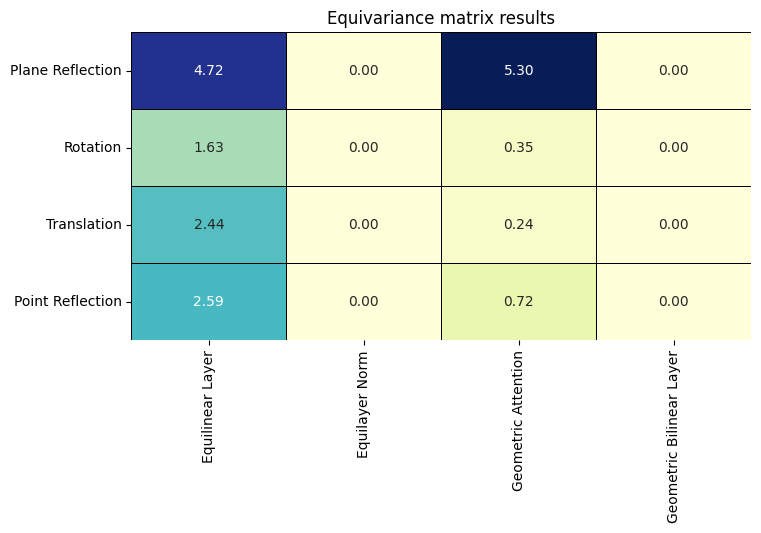

In [90]:
show_results(test, gatr, 0.1)